# Данный notebook демонстрирует полученные результаты
## Будут показаны графики реальных и прогнозируемых значений, а также heatmap и временные heatmap за различные периоды
В работе используются данные от 15 июня 2015 до 30 июня 2016 года включительно

In [1]:
#!pip install folium
# use to install folium

In [2]:
import pandas as pd
import folium
from folium import plugins, features
import numpy as np
from load_month import TripsLoader
import branca.colormap as cm
from ipywidgets import widgets, Layout, interact
import matplotlib.pyplot as plt
from IPython.display import clear_output
from datetime import datetime, time, timedelta
%matplotlib inline
figsize = (20,12)

In [3]:
# загрузка предварительно сохраненных входных данных и прогнозов
loader = TripsLoader()
coords = loader.get_coords()
loc = [(coords[1] + coords[3])/2, (coords[0] + coords[2])/2]
#
regs = np.loadtxt('data/regs.txt', delimiter=',', dtype=np.int)
reg = pd.read_csv('data/regions.csv', sep = ';', index_col=['region'])
use_reg = reg.loc[regs, :]
use_reg['lat'] = (reg.south + reg.north) / 2 
use_reg['lon'] = (reg.west + reg.east) / 2
use_reg = use_reg[['lat', 'lon']]
# загрузка координат

In [4]:
l_parse_dates = [u'tpep_pickup_datetime']
l_index_col = ['tpep_pickup_datetime']
# 
df = pd.read_csv('data/input.csv', sep=';', parse_dates=l_parse_dates, index_col=l_index_col)
preds = []
for i in range(1, 7):
    preds.append(pd.read_csv('data/pred%d.csv'%i, sep=';', parse_dates=l_parse_dates, index_col=l_index_col))
use_reg = reg.loc[regs, :]
use_reg['lat'] = (reg.south + reg.north) / 2 
use_reg['lon'] = (reg.west + reg.east) / 2
use_reg = use_reg[['lat', 'lon']]

In [5]:
def ny_map():
    folium_map = folium.Map(location=loc,
                        zoom_start=11,
                        tiles="CartoDB dark_matter")
    return folium_map

In [6]:
pred_opt = ["Real"] + ["Hour+%d"%i for i in range(1,7)]
dates = np.unique(df.index.date)

def plot_hour_map(pred_value, date, hour):
    pred_ind = pred_opt.index(pred_value) - 1
    if pred_ind == -1:
        use_df = df
    else:
        use_df = preds[pred_ind]
    dt = datetime.combine(date, time(hour))
    if dt not in df.index:
        return "Wrong datetime"
    folium_map = ny_map()
    data = reg.loc[regs, :].copy()
    trips = use_df.loc[dt, :].values
    data['trips'] = trips
    data['color'] = np.log(data.trips+1)
    data.head()

    linear = cm.LinearColormap(
        ['green', 'yellow', 'red'],
        vmin=0, vmax=data.color.max()
    )
    for ind, row in data.iterrows():
        color = linear(row.color)
        popup_text = "Region number:{}<br> Trips from this area: {}"
        popup_text = popup_text.format(ind, int(row.trips))
        features.RectangleMarker(bounds=(row.north, row.west,
                                         row.south, row.east),
                                 popup=popup_text,
                                 fill_opacity=0.25,
                                 fill_color = color,
                                 color = 'black',
                                ).add_to(folium_map)

    return folium_map

## Просмотр реального или прогнозируемого спроса на карте в конкретный момент времени
### Real - реальный спрос, hours+ прогнозируемый по заблаговременности
### Квадратики кликабельные, popup показывает номер региона и количество поездок из данного региона за час

In [7]:
style = {'description_width': 'initial'}
pred_sel = widgets.Dropdown(
    options=pred_opt,
    value = pred_opt[0],
    disabled=False,
    description="Dataset+",
    layout = Layout(width='15%', height='30px'),
    style=style
)
date_sel = widgets.DatePicker(
    description='Pick a Date',
    value=dates[0],
    disabled=False,
    options=dates,
    layout = Layout(width='25%', height='30px'),
)
time_sel = widgets.SelectionSlider(
    options=range(24),
    value=0,
    description='Time',
    disabled=False,
    layout = Layout(width='50%', height='30px'),
    style=style
)
def plot_on_click(b):
    clear_output()
    display(box)
    fmap = plot_hour_map(pred_sel.value, date_sel.value, time_sel.value)
    display(fmap)
    fmap.save('plot_hour_map.html')
    
button = widgets.Button(description='Plot!',
    disabled=False,
    layout = Layout(width='10%', height='30px'))

button.on_click(plot_on_click)
items = [pred_sel, date_sel, time_sel, button]
box = widgets.Box(items)
box

Box(children=(Dropdown(description='Dataset+', layout=Layout(height='30px', width='15%'), options=('Real', 'Ho…

In [8]:
def plot(region, start, end, pred_i):
    region = str(region)
    df[region][start:end].plot(color = 'r', figsize=figsize, label='Real')
    preds[pred_i][region][start:end].plot(color = 'b', figsize=figsize, label='Preds')
    plt.legend()
    plt.xlabel('Дата')
    plt.show()

## Просмотр графиков реального и прогнозируемого спроса за период<br>
### Hours+ - селектор переключает прогнозы по заблаговременности. За 1-6 часов до события

Box(children=(Dropdown(description='Hours+', layout=Layout(height='30px', width='10%'), options=(1, 2, 3, 4, 5…

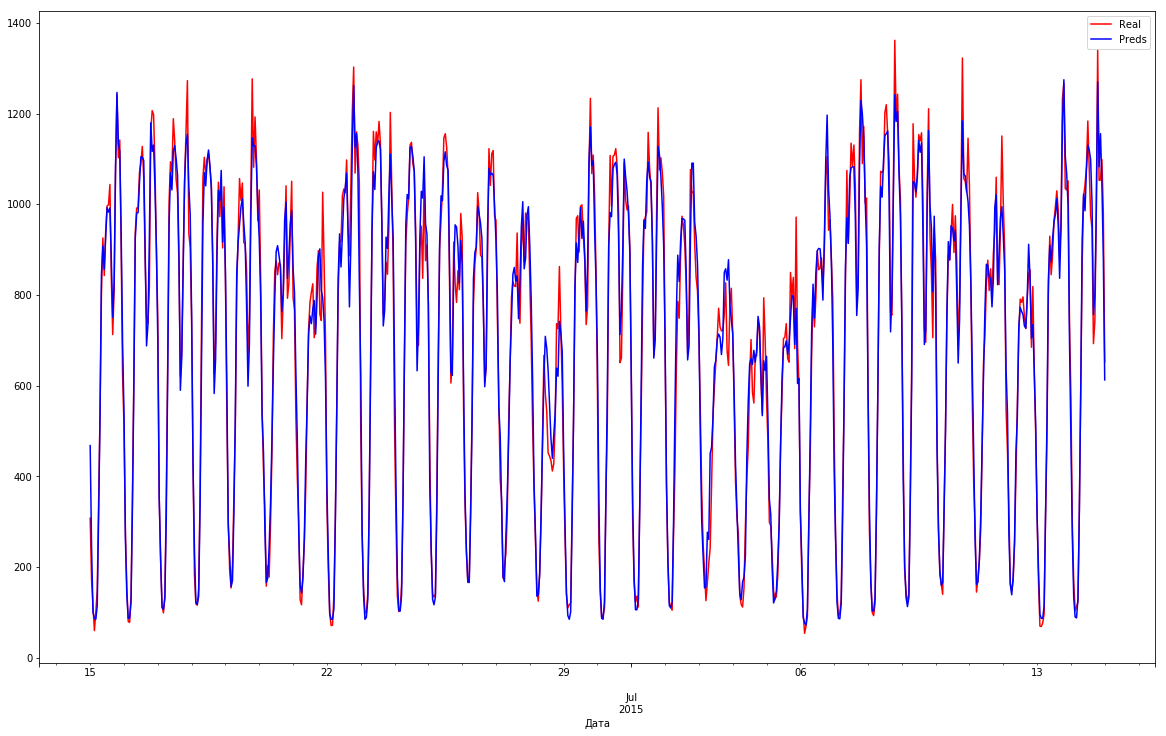

In [9]:
style = {'description_width': 'initial'}
pred_sel = widgets.Dropdown(
    options=range(1,7),
    value = 1,
    disabled=False,
    description="Hours+",
    layout = Layout(width='10%', height='30px'),
    style=style
)
reg_sel = widgets.Dropdown(
    options=regs,
    value = 1231,
    disabled=False,
    description="Region",
    layout = Layout(width='10%', height='30px'),
    style=style
)
date_sel = widgets.SelectionRangeSlider(
    options=dates,
    index=(0,30),
    description='Date',
    disabled=False,
    layout = Layout(width='70%', height='30px'),
    style=style
)
def plot_on_click(b):
    clear_output()
    display(box)
    plot(reg_sel.value, date_sel.value[0], date_sel.value[1], pred_sel.value-1)
    

button = widgets.Button(description='Plot!',
    disabled=False,
    layout = Layout(width='10%', height='30px'))

button.on_click(plot_on_click)
items = [pred_sel, reg_sel, date_sel, button]
box = widgets.Box(items)
box

In [10]:
def heat_map_6hour(date, hour):
    dt = datetime.combine(date, time(hour))
    if dt not in df.index[:-6]:
        return "Wrong datetime"
    folium_map = ny_map()
    data = []
    index = []
    for i in range(6):
        weights = np.log(preds[i].loc[dt+timedelta(hours=i), :] + 1)
        weights = weights / max(weights.max(), 1)
        weights = weights.values.reshape(-1, 1)
        data.append(np.hstack((use_reg.values, weights)).tolist())
        index.append(df.index[i].strftime('%Y-%m-%d %H:00') )

    plugins.HeatMapWithTime(data,
                            index=index,
                            auto_play=True).add_to(folium_map)
    return folium_map

## Далее моделируется ситуация, когда надо предсказать спрос на ближайшие 6 часов
### Выберите дату и время (до 18:00 30 июня 2016)<br>Будет показана анимированная heatmap со спросом на ближайшие 6 часов

In [11]:
style = {'description_width': 'initial'}
date_sel = widgets.DatePicker(
    description='Pick a Date',
    value=dates[0],
    disabled=False,
    options=dates,
    layout = Layout(width='30%', height='30px'),
)
time_sel = widgets.SelectionSlider(
    options=range(24),
    value=0,
    description='Time',
    disabled=False,
    layout = Layout(width='60%', height='30px'),
    style=style
)
def plot_on_click(b):
    clear_output()
    display(box)
    fmap = heat_map_6hour(date_sel.value, time_sel.value)
    display(fmap)
    fmap.save('heat_map_6hour.html')
    
button = widgets.Button(description='Plot!',
    disabled=False,
    layout = Layout(width='10%', height='30px'))

button.on_click(plot_on_click)
items = [date_sel, time_sel, button]
box = widgets.Box(items)
box

Box(children=(DatePicker(value=datetime.date(2015, 6, 15), description='Pick a Date', layout=Layout(height='30…

In [12]:
def heat_map_long(pred_value, start, end):
    pred_ind = pred_opt.index(pred_value) - 1
    if pred_ind == -1:
        use_df = df
    else:
        use_df = preds[pred_ind]
    
    folium_map = ny_map()
    data = []
    index = []
    start = datetime.combine(start, time(0 , 0))
    end = datetime.combine(end, time(0, 0))
    start_ind = use_df.index.get_loc(start)
    end_ind = use_df.index.get_loc(end)
    if end_ind - start_ind > 120:
        print("Wide range may slow down plotting. Try to use shorten the range to maximum 4 days")
    for hour in use_df.index[start_ind:end_ind]:
        weights = np.log(use_df.loc[hour, :] + 1)
        weights = weights / max(weights.max(), 1)
        weights = weights.values.reshape(-1, 1)
        data.append(np.hstack((use_reg.values, weights)).tolist())
        index.append(hour.strftime('%Y-%m-%d %H:00'))
    
    plugins.HeatMapWithTime(data,
                            index=index,
                            auto_play=True).add_to(folium_map)
    return folium_map

## Следующий слайд показывает анимированный heatmap с изменением спроса с течением времени
### Данные спроса также можно выбирать реальными или из предсказаний по мере заблоговременности<br>интервалы более 5 дней могут иметь проблемы с отображением

In [13]:
style = {'description_width': 'initial'}
pred_sel = widgets.Dropdown(
    options=pred_opt,
    value = pred_opt[0],
    disabled=False,
    description="Dataset+",
    layout = Layout(width='15%', height='30px'),
    style=style
)
date_sel = widgets.SelectionRangeSlider(
    options=dates,
    index=(0,4),
    description='Date',
    disabled=False,
    layout = Layout(width='75%', height='30px'),
    style=style
)
def plot_on_click(b):
    clear_output()
    display(box)
    fmap = heat_map_long(pred_sel.value, date_sel.value[0], date_sel.value[1])
    display(fmap)
    fmap.save('heat_map_long.html')
    

button = widgets.Button(description='Plot!',
    disabled=False,
    layout = Layout(width='10%', height='30px'))

button.on_click(plot_on_click)
items = [pred_sel, date_sel, button]
box = widgets.Box(items)
box

Box(children=(Dropdown(description='Dataset+', layout=Layout(height='30px', width='15%'), options=('Real', 'Ho…

# Спасибо за внимание!